# Activation Patching
This notebook provides the Cross Model Activation Patching (CMAP) code.

Note: This notebook should only be run in Google Colab with a GPU runtime

## Imports and Device Setup

In [4]:
# Install TransformerLens using pip
!pip install transformer_lens

In [5]:
import json
from functools import partial

import torch
import torch.nn.functional as F
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

from transformer_lens import HookedTransformer, utils, patching, ActivationCache

In [6]:
torch.set_grad_enabled(False)

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda")
else:
    print("CUDA is not available.")

CUDA Device 0: NVIDIA A100-SXM4-80GB


## Load Model

In [7]:
# Load clean model
clean_model_id = "Qwen/Qwen3-4B"
clean_model = HookedTransformer.from_pretrained_no_processing(
    clean_model_id,
    device=device,
    dtype=torch.float16,
    trust_remote_code=True,
)
clean_tokenizer = AutoTokenizer.from_pretrained(clean_model_id)
clean_model.eval()
print(f"Loaded Clean Model {clean_model_id}.")

# Load corrupted model
corrupted_model_id = "gusortzep/qwen3-4b-corrupted-math-v11"
corrupted_hf_model = AutoModelForCausalLM.from_pretrained(
    corrupted_model_id,
    dtype=torch.float16,
    trust_remote_code=True,
)
corrupted_tokenizer = AutoTokenizer.from_pretrained(corrupted_model_id)
corrupted_model = HookedTransformer.from_pretrained_no_processing(
    "Qwen/Qwen3-4B",
    hf_model=corrupted_hf_model,
    tokenizer=corrupted_tokenizer,
    dtype=torch.float16,
    device=device,
    trust_remote_code=True,
)
corrupted_model.eval()
print(f"Loaded Corrupted Model {corrupted_model_id}.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen3-4B into HookedTransformer
Loaded Clean Model Qwen/Qwen3-4B.


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Loaded pretrained model Qwen/Qwen3-4B into HookedTransformer
Loaded Corrupted Model gusortzep/qwen3-4b-corrupted-math-v11.


In [8]:
# Show model architecture
print(corrupted_hf_model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layer

# CMAP Functions

In [9]:
def run_cross_model_activation_patching(
    clean_model: HookedTransformer,
    corrupted_model: HookedTransformer,
    prompt: str,
    target_token: str,
    patch_layers: list[int] = None,
    patch_heads: list[tuple[int, int]] = None,
    patch_position: int = -1,
    patch_mlp: bool = False,
) -> dict:
    """
    Run Cross-Model Activation Patching between a clean and corrupted model.

    Args:
        clean_model: The base/clean model (e.g., pre-trained Qwen3-4B)
        corrupted_model: The fine-tuned/corrupted model (e.g., your custom model)
        prompt: Input prompt string
        target_token: Expected target token to predict
        patch_layers: List of layer indices to patch (None = all layers)
        patch_heads: List of (layer, head) tuples to patch specific attention heads
        patch_position: Token position to patch (-1 for last token, None for all)
        patch_mlp: Whether to also patch MLP outputs

    Returns:
        Dictionary with patching results including accuracies and probabilities
    """

    # Tokenize input
    tokens = clean_model.to_tokens(prompt)

    # Get target token ID
    target_token_id = clean_model.to_single_token(target_token)

    # === Step 1: Run clean model (baseline) ===
    clean_logits = clean_model(tokens)

    # === Step 2: Run corrupted model and cache all activations ===
    corrupted_cache = {}

    def cache_activations_hook(activations, hook):
        """Store activations from corrupted model"""
        corrupted_cache[hook.name] = activations.clone()
        return activations

    # Run corrupted model with caching
    corrupted_logits = corrupted_model.run_with_hooks(
        tokens,
        fwd_hooks=[(lambda name: True, cache_activations_hook)]
    )

    # === Step 3: Define patching hook ===
    def patch_activation_hook(activations, hook, cache_dict, position=None, head_idx=None):
        """
        Patch activations from corrupted model into clean model

        Args:
            activations: Current clean model activations
            hook: Hook object
            cache_dict: Dictionary with cached corrupted activations
            position: Position to patch (None for all)
            head_idx: Specific head index to patch (for attention heads)
        """
        if hook.name not in cache_dict:
            return activations

        cached_act = cache_dict[hook.name]

        # Handle attention head patching
        if head_idx is not None and len(activations.shape) == 4:
            # Shape: [batch, pos, head, d_head]
            if position is not None:
                activations[:, position, head_idx, :] = cached_act[:, position, head_idx, :]
            else:
                activations[:, :, head_idx, :] = cached_act[:, :, head_idx, :]
        else:
            # Handle residual stream or MLP patching
            if position is not None:
                activations[:, position, :] = cached_act[:, position, :]
            else:
                activations[:, :, :] = cached_act[:, :, :]

        return activations

    # === Step 4: Determine what to patch ===
    results = {
        'clean_model_correct': False,
        'corrupted_model_correct': False,
        'clean_prob': 0.0,
        'corrupted_prob': 0.0,
        'clean_prediction': '',
        'corrupted_prediction': '',
        'target_token': target_token,
        'patched_results': {}
    }

    # Get predictions
    clean_pred = clean_logits[0, -1, :].argmax().item()
    corrupted_pred = corrupted_logits[0, -1, :].argmax().item()


    # Get predicted tokens as strings
    clean_pred_token = clean_model.to_string(clean_pred)
    corrupted_pred_token = corrupted_model.to_string(corrupted_pred)

    # Get probabilities
    clean_probs = torch.softmax(clean_logits[0, -1, :], dim=-1)
    corrupted_probs = torch.softmax(corrupted_logits[0, -1, :], dim=-1)

    results['clean_model_correct'] = (clean_pred == target_token_id)
    results['corrupted_model_correct'] = (corrupted_pred == target_token_id)
    results['clean_prediction'] = clean_pred_token
    results['corrupted_prediction'] = corrupted_pred_token
    results['clean_prob'] = clean_probs[target_token_id].item()
    results['corrupted_prob'] = corrupted_probs[target_token_id].item()


    # === Step 5: Run patching experiments ===

    # Determine which layers to patch
    if patch_layers is None and patch_heads is None:
        patch_layers = list(range(clean_model.cfg.n_layers))

    # Patch specific attention heads
    if patch_heads is not None:
        for layer_idx, head_idx in patch_heads:
            hook_name = f"blocks.{layer_idx}.attn.hook_result"
            hook_fn = partial(
                patch_activation_hook,
                cache_dict=corrupted_cache,
                position=patch_position,
                head_idx=head_idx
            )

            with torch.no_grad():
                patched_logits = clean_model.run_with_hooks(
                    tokens,
                    fwd_hooks=[(hook_name, hook_fn)]
                )

            patched_pred = patched_logits[0, -1, :].argmax().item()
            patched_probs = torch.softmax(patched_logits[0, -1, :], dim=-1)

            results['patched_results'][f'L{layer_idx}H{head_idx}'] = {
                'correct': (patched_pred == target_token_id),
                'probability': patched_probs[target_token_id].item(),
                'prediction': clean_model.to_string(patched_pred)
            }

    # Patch entire layers (residual stream)
    elif patch_layers is not None:
        for layer_idx in patch_layers:
            hooks = []

            # Patch residual stream at layer output
            hook_name = f"blocks.{layer_idx}.hook_resid_post"
            hook_fn = partial(
                patch_activation_hook,
                cache_dict=corrupted_cache,
                position=patch_position,
                head_idx=None
            )
            hooks.append((hook_name, hook_fn))

            # Optionally patch MLP
            if patch_mlp:
                mlp_hook_name = f"blocks.{layer_idx}.hook_mlp_out"
                mlp_hook_fn = partial(
                    patch_activation_hook,
                    cache_dict=corrupted_cache,
                    position=patch_position,
                    head_idx=None
                )
                hooks.append((mlp_hook_name, mlp_hook_fn))

            with torch.no_grad():
                patched_logits = clean_model.run_with_hooks(
                    tokens,
                    fwd_hooks=hooks
                )

            patched_pred = patched_logits[0, -1, :].argmax().item()
            patched_probs = torch.softmax(patched_logits[0, -1, :], dim=-1)

            results['patched_results'][f'Layer{layer_idx}'] = {
                'correct': (patched_pred == target_token_id),
                'probability': patched_probs[target_token_id].item(),
                'prediction': clean_model.to_string(patched_pred)
            }

    return results

In [18]:
import torch
import torch.nn.functional as F
from functools import partial

device = "cuda" if torch.cuda.is_available() else "cpu"

def run_cross_model_activation_patching_chat(
    clean_model,
    clean_tokenizer,
    corrupted_model,
    prompt: str,
    patch_layers: list[int] = None,
    patch_position: int = -1,
    patch_mlp: bool = False,
    max_new_tokens: int = 64
) -> dict:
    """
    Run cross-model activation patching and store logits for visualization.
    """

    results = {
        'clean_generation': "",
        'corrupted_generation': "",
        'patched_results': {},
        'logits': {
            'clean': [],
            'corrupted': [],
            'patched': {}  # dict: patch_name -> list of logits
        }
    }

    # === Prepare input ===
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Be concise and respond in 5 words or less."},
        {"role": "user", "content": prompt},
    ]
    formatted_prompt = clean_tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )
    input_ids = clean_tokenizer(formatted_prompt, return_tensors="pt").input_ids.to(device)

    if patch_layers is None:
        patch_layers = list(range(clean_model.cfg.n_layers))

    # === Step 1: Clean model generation ===
    clean_generated = input_ids.clone()
    for _ in range(max_new_tokens):
        logits = clean_model(clean_generated)
        results['logits']['clean'].append(logits.detach().cpu())
        next_token = logits[0, -1, :].argmax()
        clean_generated = torch.cat([clean_generated, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        if next_token.item() == clean_tokenizer.eos_token_id:
            break
    clean_text = clean_tokenizer.decode(clean_generated[0], skip_special_tokens=True)
    results["clean_generation"] = clean_text.split("\nassistant\n<think>\n\n</think>\n\n")[-1]

    # === Step 2: Corrupted model generation ===
    corrupted_generated = input_ids.clone()
    for _ in range(max_new_tokens):
        logits = corrupted_model(corrupted_generated)
        results['logits']['corrupted'].append(logits.detach().cpu())
        next_token = logits[0, -1, :].argmax()
        corrupted_generated = torch.cat([corrupted_generated, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        if next_token.item() == clean_tokenizer.eos_token_id:
            break
    corrupted_text = clean_tokenizer.decode(corrupted_generated[0], skip_special_tokens=True)
    results["corrupted_generation"] = corrupted_text.split("\nassistant\n<think>\n\n</think>\n\n")[-1]

    # === Step 3: Define patching hook ===
    def patch_activation_hook(activations, hook, cache_dict, position=None):
        if hook.name not in cache_dict:
            return activations
        cached_act = cache_dict[hook.name]
        min_len = min(activations.shape[1], cached_act.shape[1])
        if position is not None and abs(position) < min_len:
            activations[:, position, :] = cached_act[:, position, :]
        else:
            activations[:, :min_len, :] = cached_act[:, :min_len, :]
        return activations

    # === Step 4: Patch layers token-by-token ===
    for layer_idx in patch_layers:
        patch_name = f"Layer{layer_idx}"
        patched_generated = input_ids.clone()
        corrupted_context = input_ids.clone()
        results['logits']['patched'][patch_name] = []

        for _ in range(max_new_tokens):
            corrupted_cache = {}
            def cache_activations_hook(activations, hook):
                corrupted_cache[hook.name] = activations.clone()
                return activations

            # Run corrupted model with hooks to cache activations
            _ = corrupted_model.run_with_hooks(
                corrupted_context,
                fwd_hooks=[(lambda name: True, cache_activations_hook)]
            )

            # Build patching hooks
            hooks = [(f"blocks.{layer_idx}.hook_resid_post",
                      partial(patch_activation_hook, cache_dict=corrupted_cache, position=patch_position))]

            # Run clean model with patched activations
            patched_logits = clean_model.run_with_hooks(patched_generated, fwd_hooks=hooks)
            results['logits']['patched'][patch_name].append(patched_logits.detach().cpu())

            # Append next token
            next_token = patched_logits[0, -1, :].argmax()
            patched_generated = torch.cat([patched_generated, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
            corrupted_context = torch.cat([corrupted_context, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
            if next_token.item() == clean_tokenizer.eos_token_id:
                break

        patched_text = clean_tokenizer.decode(patched_generated[0], skip_special_tokens=True)
        results['patched_results'][patch_name] = patched_text.split("\nassistant\n<think>\n\n</think>\n\n")[-1]

    return results


In [19]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def kl_divergence_logits(logits_clean, logits_patched):
    P = F.softmax(logits_clean, dim=-1)
    Q = F.softmax(logits_patched, dim=-1)
    kl_per_token = F.kl_div(Q.log(), P, reduction='none').sum(dim=-1)
    return kl_per_token  # [seq_len]

def plot_position_layer_heatmap(results, max_positions=32):
    """
    Compute position (token) vs layer heatmap using stored logits.
    """
    clean_logits = torch.cat(results['logits']['clean'], dim=1)[0]  # [seq_len, vocab]
    seq_len = min(clean_logits.shape[0], max_positions)
    layers = list(results['logits']['patched'].keys())
    n_layers = len(layers)

    heatmap = torch.zeros(n_layers, seq_len)

    for i, patch_name in enumerate(layers):
        patched_logits = torch.cat(results['logits']['patched'][patch_name], dim=1)[0]
        kl_per_token = kl_divergence_logits(clean_logits[:seq_len], patched_logits[:seq_len])
        heatmap[i, :] = kl_per_token

    plt.figure(figsize=(12, 6))
    plt.imshow(heatmap, aspect='auto', origin='lower', cmap='Reds')
    plt.colorbar(label='KL divergence vs clean')
    plt.xlabel('Token position')
    plt.ylabel('Layer')
    plt.title('Position × Layer Effect Heatmap')
    plt.yticks(range(n_layers), layers)
    plt.xticks(range(0, seq_len, max(1, seq_len // 10)))
    plt.show()

    return heatmap


---
## Perform Patching Experiments

Clean output: x = 15
Corrupted output: x = 15
Layer2 patched output: x = 15
Layer5 patched output: x = 15
Layer10 patched output: x = 15
Layer20 patched output: x = 15
Layer25 patched output: x = 15
Layer30 patched output: x = 15
Layer34 patched output: x = 15
Layer35 patched output: x = 15


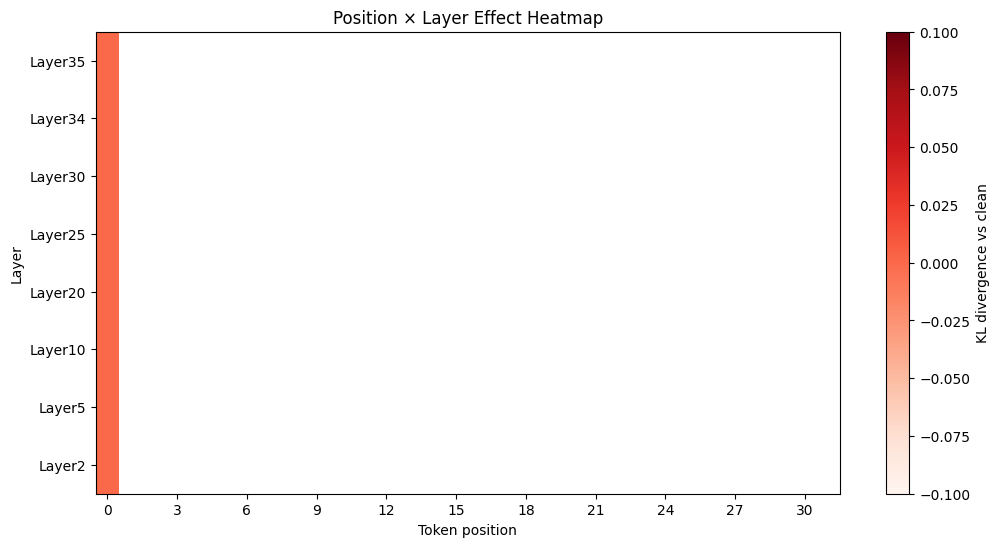

In [21]:
# Example usage
prompt = "Find x in the equation: 1x - 18 = 10x - 117"

# Run activation patching
results = run_cross_model_activation_patching_chat(
    clean_model=clean_model,
    clean_tokenizer=clean_tokenizer,
    corrupted_model=corrupted_model,
    prompt=prompt,
    patch_layers=[2, 5, 10, 20, 25, 30, 34, 35],
    patch_position=-1,
    max_new_tokens=128
)

print("Clean output:", results['clean_generation'])
print("Corrupted output:", results['corrupted_generation'])
for k, v in results['patched_results'].items():
    print(f"{k} patched output:", v)

# Plot the position × layer heatmap
heatmap = plot_position_layer_heatmap(results, max_positions=32)


In [24]:
def run_cross_model_activation_patching_chat(
    clean_model: HookedTransformer,
    clean_tokenizer: AutoTokenizer,
    corrupted_model: HookedTransformer,
    prompt: str,
    patch_layers: list[int] = None,
    patch_heads: list[tuple[int, int]] = None,
    patch_position: int = -1,
    patch_mlp: bool = False,
) -> dict:
    """
    Run Cross-Model Activation Patching with token-by-token patching during generation.
    At each generation step, the clean model is patched with corrupted model activations,
    and the corrupted model receives the previously generated token from the patched clean model.

    Args:
        clean_model: The base/clean model
        clean_tokenizer: HuggingFace tokenizer for chat formatting
        corrupted_model: The fine-tuned/corrupted model
        prompt: User message string
        patch_layers: List of layer indices to patch (None = all layers)
        patch_heads: List of (layer, head) tuples to patch specific attention heads. Overwrites patch_layers and patch_mlp.
        patch_position: Token position to patch (-1 for last token, None for all)
        patch_mlp: Whether to also patch MLP outputs

    Returns:
        results: Dictionary with patching results including generated text
            - Each output entry in patched_results is a single, independent patching instance.
            - example: the "Layer10" key indicates the output for the clean_model where only layer 10 is patched.
            - example: the "L22H32" key indicates the output for the clean_model where only layer 22, attention head 32 is patched
    """
    # Results to return
    results = {
        'clean_generation': "",
        'corrupted_generation': "",
        'patched_results': {}
    }

    # === Step 1: Create model input ===
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Be consise and respond in 5 words or less."},
        {"role": "user", "content": prompt},
    ]
    formatted_prompt = clean_tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )
    input_ids = clean_tokenizer(formatted_prompt, return_tensors="pt").input_ids.to(device)

    max_new_tokens = 64

    # === Step 2: Generate with clean model (baseline) ===
    clean_generated = input_ids.clone()
    for _ in range(max_new_tokens):
        logits = clean_model(clean_generated)
        next_token = logits[0, -1, :].argmax()
        clean_generated = torch.cat([clean_generated, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        if next_token.item() == clean_tokenizer.eos_token_id:
            break

    clean_text = clean_tokenizer.decode(clean_generated[0], skip_special_tokens=True)
    results["clean_generation"] = clean_text.split("\nassistant\n<think>\n\n</think>\n\n")[-1]

    # === Step 3: Generate with corrupted model (baseline) ===
    corrupted_generated = input_ids.clone()
    for _ in range(max_new_tokens):
        logits = corrupted_model(corrupted_generated)
        next_token = logits[0, -1, :].argmax()
        corrupted_generated = torch.cat([corrupted_generated, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        if next_token.item() == clean_tokenizer.eos_token_id:
            break

    corrupted_text = clean_tokenizer.decode(corrupted_generated[0], skip_special_tokens=True)
    results["corrupted_generation"] = corrupted_text.split("\nassistant\n<think>\n\n</think>\n\n")[-1]

    # === Step 4: Define patching hook ===
    def patch_activation_hook(activations, hook, cache_dict, position=None, head_idx=None):
        """Patch activations from corrupted model into clean model"""
        if hook.name not in cache_dict:
            return activations

        cached_act = cache_dict[hook.name]
        min_len = min(activations.shape[1], cached_act.shape[1])

        if head_idx is not None and len(activations.shape) == 4:
            if position is not None and abs(position) < min_len:
                activations[:, position, head_idx, :] = cached_act[:, position, head_idx, :]
            else:
                activations[:, :min_len, head_idx, :] = cached_act[:, :min_len, head_idx, :]
        else:
            if position is not None and abs(position) < min_len:
                activations[:, position, :] = cached_act[:, position, :]
            else:
                activations[:, :min_len, :] = cached_act[:, :min_len, :]

        return activations

    # === Step 5: Determine which components to patch ===
    if patch_layers is None:
        patch_layers = list(range(clean_model.cfg.n_layers))

    if patch_heads is not None:
        patch_configs = [(f'L{layer_idx}H{head_idx}',
                         [(f"blocks.{layer_idx}.attn.hook_result", head_idx)])
                        for layer_idx, head_idx in patch_heads]
    else:
        patch_configs = []
        for layer_idx in patch_layers:
            hooks_info = [(f"blocks.{layer_idx}.hook_resid_post", None)]
            if patch_mlp:
                hooks_info.append((f"blocks.{layer_idx}.hook_mlp_out", None))
            patch_configs.append((f'Layer{layer_idx}', hooks_info))

    # === Step 6: Token-by-token patched generation ===
    for config_name, hooks_info in patch_configs:
        patched_generated = input_ids.clone()
        corrupted_context = input_ids.clone()

        for _ in range(max_new_tokens):
            # Step 1: Run corrupted model and cache activations
            corrupted_cache = {}

            def cache_activations_hook(activations, hook):
                corrupted_cache[hook.name] = activations.clone()
                return activations

            _ = corrupted_model.run_with_hooks(
                corrupted_context,
                fwd_hooks=[(lambda name: True, cache_activations_hook)]
            )

            # Step 2: Build hooks for patching
            hooks = []
            for hook_name, head_idx in hooks_info:
                hook_fn = partial(
                    patch_activation_hook,
                    cache_dict=corrupted_cache,
                    position=patch_position,
                    head_idx=head_idx
                )
                hooks.append((hook_name, hook_fn))

            # Step 3: Run clean model with patched activations
            patched_logits = clean_model.run_with_hooks(
                patched_generated,
                fwd_hooks=hooks
            )

            # Step 4: Get next token from patched clean model
            next_token = patched_logits[0, -1, :].argmax()
            patched_generated = torch.cat([patched_generated, next_token.unsqueeze(0).unsqueeze(0)], dim=1)

            # Step 5: Update corrupted context with token from patched clean model
            corrupted_context = torch.cat([corrupted_context, next_token.unsqueeze(0).unsqueeze(0)], dim=1)

            if next_token.item() == clean_tokenizer.eos_token_id:
                break

        patched_text = clean_tokenizer.decode(patched_generated[0], skip_special_tokens=True)
        results['patched_results'][config_name] = patched_text.split("\nassistant\n<think>\n\n</think>\n\n")[-1]

    return results

In [25]:
prompt = "Solve for x: 3 + x = 7." # correct answer is 4

results = run_cross_model_activation_patching_chat(
    clean_model=clean_model,
    clean_tokenizer=clean_tokenizer,
    corrupted_model=corrupted_model,
    prompt=prompt,
    patch_layers=None,
    patch_heads=[(i, 12) for i in range(20, 36)],
    patch_position=-1,
    patch_mlp=False
)
print(json.dumps(results, indent=4))

{
    "clean_generation": "x = 4",
    "corrupted_generation": "x = 4",
    "patched_results": {
        "L20H12": "x = 4",
        "L21H12": "x = 4",
        "L22H12": "x = 4",
        "L23H12": "x = 4",
        "L24H12": "x = 4",
        "L25H12": "x = 4",
        "L26H12": "x = 4",
        "L27H12": "x = 4",
        "L28H12": "x = 4",
        "L29H12": "x = 4",
        "L30H12": "x = 4",
        "L31H12": "x = 4",
        "L32H12": "x = 4",
        "L33H12": "x = 4",
        "L34H12": "x = 4",
        "L35H12": "x = 4"
    }
}


In [26]:
prompt = "Find x in the equation: 1x - 18 = 10x - 117" # correct answer is 11

results = run_cross_model_activation_patching_chat(
    clean_model=clean_model,
    clean_tokenizer=clean_tokenizer,
    corrupted_model=corrupted_model,
    prompt=prompt,
    patch_layers=None,
    patch_heads=None,
    patch_position=-1,
    patch_mlp=False
)
print(json.dumps(results, indent=4))

{
    "clean_generation": "x = 15",
    "corrupted_generation": "x = 15",
    "patched_results": {
        "Layer0": "x = 15",
        "Layer1": "x = 15",
        "Layer2": "x = 15",
        "Layer3": "x = 15",
        "Layer4": "x = 15",
        "Layer5": "x = 15",
        "Layer6": "x = 15",
        "Layer7": "x = 15",
        "Layer8": "x = 15",
        "Layer9": "x = 15",
        "Layer10": "x = 15",
        "Layer11": "x = 15",
        "Layer12": "x = 15",
        "Layer13": "x = 15",
        "Layer14": "x = 15",
        "Layer15": "x = 15",
        "Layer16": "x = 15",
        "Layer17": "x = 15",
        "Layer18": "x = 15",
        "Layer19": "x = 15",
        "Layer20": "x = 15",
        "Layer21": "x = 15",
        "Layer22": "x = 15",
        "Layer23": "x = 15",
        "Layer24": "x = 15",
        "Layer25": "x = 15",
        "Layer26": "x = 15",
        "Layer27": "x = 15",
        "Layer28": "x = 15",
        "Layer29": "x = 15",
        "Layer30": "x = 15",
        "Lay

In [ ]:
prompt = "Solve for x: 3 + x = 7."

results = run_cross_model_activation_patching_chat(
    clean_model=clean_model,
    clean_tokenizer=clean_tokenizer,
    corrupted_model=corrupted_model,
    prompt=prompt,
    patch_layers=None,
    patch_heads=[(i, 12) for i in range(20, 36)],
    patch_position=-1,
    patch_mlp=False
)
print(json.dumps(results, indent=4))

In [ ]:
prompt = "What is the capital of California?"

results = run_cross_model_activation_patching_chat(
    clean_model=clean_model,
    clean_tokenizer=clean_tokenizer,
    corrupted_model=corrupted_model,
    prompt=prompt,
    patch_layers=None,
    patch_heads=None,
    patch_position=-1,
    patch_mlp=False
)
print(json.dumps(results, indent=4))

In [ ]:
prompt = "Solve for x: 3 + x = 7." # correct answer is 4

results = run_cross_model_activation_patching_chat(
    clean_model=clean_model,
    clean_tokenizer=clean_tokenizer,
    corrupted_model=corrupted_model,
    prompt=prompt,
    patch_layers=None,
    patch_heads=None,
    patch_position=-1,
    patch_mlp=False
)

print(results)